# Dantzig Wolfe Decomposition

In [2]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
import itertools

import pandas as pd
import numpy as np

def fsmodel():
    model = ConcreteModel()
    
    # 5D Array
    model.gen = Set(initialize=[1, 2])  # Generators
    model.Periods = Set(initialize=[1, 2, 3])  # Time periods
    model.days = Set(initialize=[1, 2, 3])  # Demand scenario for time period 1
    
    # Total Scenarios
    
    file_path = 'newgenexp.xlsx'
    sheet_name = 'DIC'  # Specify the sheet name or sheet number
    
    # Load the data into a pandas DataFrame
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    c = {}
    for i in range(0,df.shape[0]):
        c[df['Generator'][i]] = df['Ammortized Fixed operating cost($)'][i]
    model.c = Param(model.gen, initialize=c)  # Fixed cost per unit capacity of generator j
    
    sheet_name = 'FIXOP'  # Specify the sheet name or sheet number
    
    # Load the data into a pandas DataFrame
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    f = {}
    for i in range(0,df.shape[0]):
        f[(df['Generator'][i],df['Period'][i])] = df['FIXOP'][i]
    model.f = Param(model.gen,model.Periods, initialize=f)  # Fixed cost per unit capacity of generator j
    
    sheet_name = 'Additional cost'  # Specify the sheet name or sheet number
    
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    g = {}
    for i in range(0,df.shape[0]):
        g[df['Day'][i]] = df['Cost'][i]
    model.g = Param(model.days, initialize=g)
    
    
    
    d = {}
    
    sheet_name = 'Demand'
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    for i in range(0,df.shape[0]):
        d[df['Day'][i],df['Period'][i]]= df['Demand (KWh)'][i]
        
                           
                   
    model.d = Param(model.Periods,model.days, initialize=d)  # Fixed cost per unit capacity of generator j
    
                           
       
    a = {}    
    sheet_name = 'Availability'
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    for i in range(0,df.shape[0]):
        a[df['Day'][i],df['Period'][i],df['Generator'][i]]= df['Availibility'][i]
        
                           
    model.a = Param(model.Periods,model.days,model.gen, initialize=a)  # Fixed cost per unit capacity of generator j
    
    # Variables
    model.x = Var(model.gen, domain=NonNegativeReals)  # Installed capacity of generator j
    model.y = Var(model.days,model.Periods,  model.gen, domain=NonNegativeReals)  # Operating level of generator j
    model.y_purchased = Var(model.days,model.Periods,domain=NonNegativeReals)  # Additional capacity purchased
    # Objective function
    def objective_rule(model):
        fixed_cost = 3*sum(model.c[j] * model.x[j] for j in model.gen)
        operating_cost = sum(sum(sum(model.f[j,i] * model.y[s,i,j] for j in model.gen) + model.g[s] * model.y_purchased[s,i] for i in model.Periods) for s in model.days)
        return fixed_cost + operating_cost
    
    model.obj = Objective(rule=objective_rule, sense=minimize)
    
    # Constraints
    #Constraint for fixing x values
    

    # Demand satisfaction constraints
    def demand_satisfaction_rule(model, a,i):
        return sum(model.y[s,i,j] for j in model.gen) + model.y_purchased[s,i] >= model.d[s,i]
    model.demand_satisfaction_constraint = Constraint(model.days,model.Periods,  rule=demand_satisfaction_rule)
    
    # Availability constraints
    def availability_rule(model, s,i,gen):
        return model.y[s,i,gen] <= model.a[s,i,gen] * model.x[gen]
    model.availability_constraint = Constraint(model.days,model.Periods, model.gen, rule=availability_rule)
    return model


In [3]:
file_path = 'newgenexp.xlsx'
sheet_name = 'FIXOP'  # Specify the sheet name or sheet number

# Load the data into a pandas DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)
f = {}
for i in range(0,df.shape[0]):
    f[(df['Generator'][i],df['Period'][i])] = df['FIXOP'][i]

sheet_name = 'Additional cost'  # Specify the sheet name or sheet number

df = pd.read_excel(file_path, sheet_name=sheet_name)
g = {}
for i in range(0,df.shape[0]):
    g[df['Day'][i]] = df['Cost'][i]

dem = {}

sheet_name = 'Demand'
df = pd.read_excel(file_path, sheet_name=sheet_name)
for i in range(0,df.shape[0]):
    dem[df['Day'][i],df['Period'][i]]= df['Demand (KWh)'][i]
    
av = {}    
sheet_name = 'Availability'
df = pd.read_excel(file_path, sheet_name=sheet_name)
for i in range(0,df.shape[0]):
    av[df['Day'][i],df['Period'][i],df['Generator'][i]]= df['Availibility'][i]
def heuristic(xval,s):
    sp = ConcreteModel()
    #sp.dual = Suffix(direction=Suffix.IMPORT)
    sp.gen = Set(initialize=[1, 2])  # Generators
    sp.Periods = Set(initialize=[1, 2, 3])
    sp.y = Var(sp.Periods,sp.gen, domain=NonNegativeReals)  # Operating level of generator j
    sp.y_purchased = Var(sp.Periods, domain=NonNegativeReals)  # Additional capacity purchased
    def objective_rule(model):
        operating_cost = sum(sum(f[j,i] * model.y[i,j] for j in model.gen) + g[s] * model.y_purchased[i] for i in model.Periods)
        return operating_cost
    
    sp.obj = Objective(rule=objective_rule, sense=minimize)
    
    # Constraints
    #Constraint for fixing x values
    

    # Demand satisfaction constraints
    def demand_satisfaction_rule(model, i):
        return -sum(model.y[i,j] for j in model.gen) - model.y_purchased[i] <=-dem[s,i] 
    sp.demand_satisfaction_constraint = Constraint(sp.Periods, rule=demand_satisfaction_rule)
    
    # Availability constraints
    def availability_rule(model, i, gen):
        return model.y[i,gen]- av[s,i,gen] * xval[gen-1] <= 0
    sp.availability_constraint = Constraint(sp.Periods, sp.gen, rule=availability_rule)
    results = opt.solve(sp)
    return sp.obj()

## Master problem : 
To implement the Dantzig Wolfe Decomposition, we formulate a master problem as follows:
$$
    \begin{aligned}
        &\min \quad  \sum_{s \in S}\sum_{k \in K_{\lambda,s}} \lambda_s^k\left(\sum_{j \in \set{J}}c_{j}\tilde{x}_{x,s,j}^k+\tilde{x}_{z,s}^k\right)              +\sum_{s \in S} \sum_{k \in K_{\theta,s}} \theta_s^k\left (\sum_{j \in \set{J}}c_{j}\tilde{w}_{x,s,j}^k+\tilde{w}_{z,s}^k\right)\\ 
        &\text { s. t.} \quad  \sum_{k \in K_{\lambda,1}} \lambda_1^k \tilde{x}_{x,1,j}^k+\sum_{k \in K_{\theta,1}} \theta_1^k \tilde{w}_{x,1,j}                  =\sum_{k \in K_{\lambda,a}}\lambda_s^k \tilde{x}_{x,s,j}+\sum_{k \in K_{\theta,s}} \theta_s^k \tilde{w}_{x,1,j}\quad\forall s \in \set{S},s             \neq 1\\
        &\sum_{k \in K_{\lambda,s}} \lambda_s^k = 1\quad \forall  s \in \set{S}\\ 
        &\lambda_s^k \geq 0,\quad \forall k \in S_{\lambda,s},\;s \in \set{S}, \quad  \theta_s^k \geq 0\quad k \in S_{\theta,s},\;s \in \set{S}       
    \end{aligned}
$$

In [4]:
file_path = 'newgenexp.xlsx'
sheet_name = 'DIC'  # Specify the sheet name or sheet number

# Load the data into a pandas DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)
c = {}
for i in range(0,df.shape[0]):
    c[df['Generator'][i]] = df['Ammortized Fixed operating cost($)'][i]

mp_obj_list= []
def create_mp(to_print=0):
    mp = ConcreteModel()
    mp.dual = Suffix(direction=Suffix.IMPORT)
    # 5D Array
    mp.gen = Set(initialize=[1, 2])  # Generators
    mp.days = Set(initialize=[1, 2, 3])  # Demand scenario for time period 1
    lambda_len = {}
    for k in days:
        lambda_len[k] = len(x_c[k])
    mp.lambda_1 = Var(range(lambda_len[1]),domain=NonNegativeReals)
    mp.lambda_2 = Var(range(lambda_len[2]),domain=NonNegativeReals)
    mp.lambda_3 = Var(range(lambda_len[3]),domain=NonNegativeReals)
    def match1(model,j):
        return sum(model.lambda_1[i]*x_c[1][i][j-1] for i in range(lambda_len[1])) - sum(model.lambda_2[i]*x_c[2][i][j-1] for i in range(lambda_len[2]))==0
    mp.match1_constraint = Constraint(mp.gen, rule=match1)
    def match2(model,j):
        return sum(model.lambda_1[i]*x_c[1][i][j-1] for i in range(lambda_len[1])) - sum(model.lambda_3[i]*x_c[3][i][j-1] for i in range(lambda_len[3]))==0
    mp.match2_constraint = Constraint(mp.gen, rule=match2)
    mp.lam1con = Constraint(rule=lambda mp:sum(mp.lambda_1[i] for i in range(lambda_len[1]))==1)
    mp.lam2con = Constraint(rule=lambda mp:sum(mp.lambda_2[i] for i in range(lambda_len[2]))==1)
    mp.lam3con = Constraint(rule=lambda mp:sum(mp.lambda_3[i] for i in range(lambda_len[3]))==1)
    def objective_rule(model):
        fixed_cost = sum(c[j] * sum(model.lambda_1[i]*x_c[1][i][j-1] for i in range(lambda_len[1])) for j in model.gen)+sum(c[j] * sum(model.lambda_2[i]*x_c[2][i][j-1] for i in range(lambda_len[2])) for j in model.gen)+sum(c[j] * sum(model.lambda_3[i]*x_c[3][i][j-1] for i in range(lambda_len[3])) for j in model.gen)
        operating_cost = sum(model.lambda_1[i]*z_c[1][i] for i in range(lambda_len[1]))+sum(model.lambda_2[i]*z_c[2][i] for i in range(lambda_len[2]))+sum(model.lambda_3[i]*z_c[3][i] for i in range(lambda_len[3]))
        return fixed_cost + operating_cost
    mp.obj = Objective(rule=objective_rule, sense=minimize)
    results = opt.solve(mp)
    print(mp.obj())
    
    if(to_print==1):
        mp.pprint()
        print([sum(mp.lambda_1[i]()*x_c[1][i][0] for i in range(lambda_len[1])),sum(mp.lambda_1[i]()*x_c[1][i][1] for i in range(lambda_len[1]))]) 
        print([sum(mp.lambda_2[i]()*x_c[2][i][0] for i in range(lambda_len[2])),sum(mp.lambda_2[i]()*x_c[2][i][1] for i in range(lambda_len[2]))])
        print([sum(mp.lambda_3[i]()*x_c[3][i][0] for i in range(lambda_len[3])),sum(mp.lambda_3[i]()*x_c[3][i][1] for i in range(lambda_len[3]))])
    else:
        mp_obj_list.append(mp.obj())
    return [mp.dual[mp.match1_constraint[1]],mp.dual[mp.match1_constraint[2]],mp.dual[mp.match2_constraint[1]],mp.dual[mp.match2_constraint[2]]],[mp.dual[mp.lam1con],mp.dual[mp.lam2con],mp.dual[mp.lam3con]]
    
    

## Subproblem
We formulate pricing subproblems as follows:
$$
\begin{aligned}
\text{SP}_{1} : \min &\sum_{j \in \set{J}}c_{j}x_{j}+z-\sum_{j \in \set{J}}\sum_{s \in \set{S},s \neq 1}\nu_{s,j}x_j \\
\text{s.t.} \quad &  z =  \sum_{j \in \set{J}}c_{j}x_{j} + \sum_{i\in \set{I}}\left(\sum_{j \in \set{J}}\left(f_{i,j}y_{i,j} \right)+g_{1} \tilde{y}_{i}\right) & \\
         & y_{i,j} \leq a_{1,i,j}x_{j} \quad \forall\: i \in \set{I},j \in \set{J} & \\
        & \sum_{j \in \set{J}}y_{i,j}+ \tilde{y}_{i} \geq d_{1,i}\quad \forall\: i \in \set{I}& \\
         & y_{i,j} \geq 0 \quad \forall\: i \in \set{I},j \in \set{J} & \\
          &  \tilde{y}_{i} \geq 0 \quad \forall\: i \in \set{I} & \\
          & x_j \geq 0 \quad \forall\; j\in \set{J} & \\
           & x_j \leq M \quad \forall\; j\in \set{J}
\end{aligned}
$$
$$
\begin{aligned}
\text{SP}_{s\in \set{S},s\neq 1} :  \min &\sum_{j \in \set{J}}c_{j}x_{j}+z+\sum_{j \in \set{J}}\nu_{s,j}x \\
\text{s.t.} \quad &  z =  \sum_{j \in \set{J}}c_{j}x_{j} + \sum_{i\in \set{I}}\left(\sum_{j \in \set{J}}\left(f_{i,j}y_{i,j} \right)+g_{s} \tilde{y}_{i}\right) & \\
         & y_{i,j} \leq a_{s,i,j}x_{j} \quad \forall\: i \in \set{I},j \in \set{J} & \\
        & \sum_{j \in \set{J}}y_{i,j}+ \tilde{y}_{i} \geq d_{s,i}\quad \forall\: i \in \set{I}& \\
         & y_{i,j} \geq 0 \quad \forall\: i \in \set{I},j \in \set{J} & \\
          &  \tilde{y}_{i} \geq 0 \quad \forall\: i \in \set{I} & \\
          & x_j \geq 0 \quad \forall\; j\in \set{J} & \\
          & x_j \leq M \quad \forall\; j\in \set{J}
\end{aligned}
$$

In [5]:
def pricing_problem(s,q,r):
    sp = ConcreteModel()
    sp.dual = Suffix(direction=Suffix.IMPORT)
    sp.gen = Set(initialize=[1, 2])  # Generators
    sp.Periods = Set(initialize=[1, 2, 3])
    sp.x = Var(sp.gen, domain=NonNegativeReals)  # Operating level of generator j
    sp.z = Var(domain=NonNegativeReals)
    sp.y = Var(sp.Periods,sp.gen, domain=NonNegativeReals)  # Operating level of generator j
    sp.y_purchased = Var(sp.Periods, domain=NonNegativeReals)  # Additional capacity purchased
    if(s==1):
        def objective_rule(model):
            cost = -(q[0]+q[2])*model.x[1] -(q[1]+q[3])*model.x[2]+sum(c[j] * model.x[j] for j in model.gen)+model.z
            #cost = -(q[0]+q[2])*model.x[1] -(q[1]+q[3])*model.x[2]+model.z
            return cost
        
        sp.obj = Objective(rule=objective_rule, sense=minimize)
    elif(s==2):
        def objective_rule(model):
            cost = q[0]*model.x[1]+q[1]*model.x[2]+sum(c[j] * model.x[j] for j in model.gen)+model.z
            return cost
        
        sp.obj = Objective(rule=objective_rule, sense=minimize)
    else:
        def objective_rule(model):
            cost = q[2]*model.x[1]+q[3]*model.x[2]+sum(c[j] * model.x[j] for j in model.gen)+model.z
            return cost
        
        sp.obj = Objective(rule=objective_rule, sense=minimize)
    
    # Constraints
    #Constraint for fixing x values
    

    # Demand satisfaction constraints
    def demand_satisfaction_rule(model, i):
        return -sum(model.y[i,j] for j in model.gen) - model.y_purchased[i] <=-dem[s,i] 
    sp.demand_satisfaction_constraint = Constraint(sp.Periods, rule=demand_satisfaction_rule)
    
    # Availability constraints
    def availability_rule(model, i, gen):
        return model.y[i,gen]- av[s,i,gen] * model.x[gen] <= 0
    sp.availability_constraint = Constraint(sp.Periods, sp.gen, rule=availability_rule)
    sp.constraint_base = Constraint(sp.gen, rule=lambda sp, j:sp.x[j]<=10000)
    sp.constraint_base1 = Constraint(rule=lambda sp:sp.z == sum(sum(f[j,i] * sp.y[i,j] for j in sp.gen) + g[s] * sp.y_purchased[i] for i in sp.Periods))
    results = opt.solve(sp)
    print(sp.obj())
    print(r[s-1]-sp.obj())
    if(sp.obj()<r[s-1]-0.000000001):
        x_c[s].append([sp.x[1](),sp.x[2]()])
        z_c[s].append(sp.z())
        return "Column added",sp.obj()
    else:
        return "Column not required",sp.obj()

# Implementing Dantzig Wolfe decomposition
We solve the master problem and pricing subproblems iteratively, with columns  added to the master problem based on the pricing problem


In [6]:

opt = SolverFactory('gurobi')
opt.options['DualReductions'] = 0
x_c = {}
z_c = {}
days = [1,2,3]
periods = [1,2,3]
gen = [1,2]
for s in days:
    x_c[s] = [[0,0]]
    z_c[s] = [heuristic([0,0],s)]
LB = float('-inf')
LB_lis = []
iter = 0
while(1):
    iter = iter+1
    q,r = create_mp()
    c_n = 0
    val = 0
    for s in days:
        message,pric_obj =  pricing_problem(s,q,r)
        val = val+pric_obj
        print(message)
        if(message == "Column not required"):
            c_n = c_n+1
    LB = max(LB,val)
    LB_lis.append(LB)
    if(c_n==3):
        print("yes")
        #print(x)
        create_mp(1)
        break
        
        

504999.525
98222.22222222222
21777.77777777778
Column added
38469.69696969696
21530.30303030304
Column added
150833.20666666667
174166.31833333336
Column added
504999.525
-5261399.288095239
5381399.288095239
Column added
-406951.38571428595
466951.38571428595
Column added
177121.18545454546
147878.33954545457
Column added
390699.2411726833
-115523.73881869254
154587.42035283078
Column added
18615.685072764994
8020.349565780016
Column added
300951.62083368027
24047.904166319757
Column added
373679.83280543605
30957.888328919682
27620.91749247865
Column added
20294.117647058818
6428.571428571424
Column added
282997.26421185886
5381.073696548643
Column added
365205.7247677371
54372.57824143073
10545.454545454515
Column added
20537.28384351782
1681.8907045770684
Column added
274454.1520125261
3614.365420230839
Column added
359756.718273224
61180.327868852444
3737.7049180327886
Column added
20978.14207650273
3.637978807091713e-12
Column not required
273860.5434098361
0.0
Column not required

In [7]:
iter

7

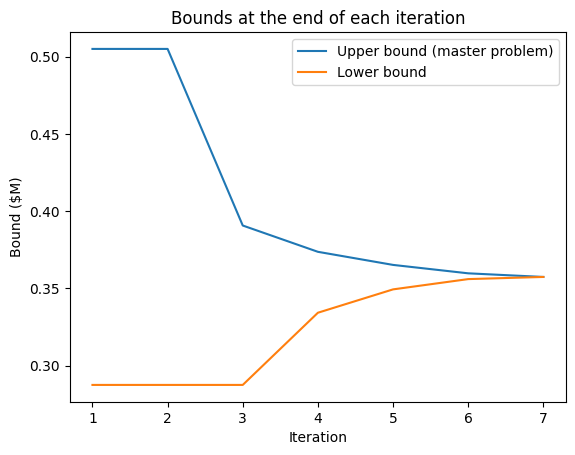

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(range(1,len(mp_obj_list)+1), np.array(mp_obj_list)/10**6,range(1,len(mp_obj_list)+1),np.array(LB_lis)/10**6)
plt.title('Bounds at the end of each iteration')
plt.xlabel('Iteration')
plt.ylabel('Bound ($M)')
plt.legend(['Upper bound (master problem)','Lower bound '])
plt.savefig('dw_mp.pdf')
plt.show()

In [9]:
LB_lis

[287525.1258585858,
 287525.1258585858,
 287525.1258585858,
 334249.27018783736,
 349364.01409747463,
 356019.0133551912,
 357408.97890909086]

In [10]:
mp_obj_list

[504999.525,
 504999.525,
 390699.2411726833,
 373679.83280543605,
 365205.7247677371,
 359756.718273224,
 357408.9789090909]